### This file contains the code for training our model on EMG data only 

In [9]:
from libemg import streamers, data_handler, filtering, gui, emg_predictor, feature_extractor, utils
import os
import json
import time
from os import walk

import numpy as np
from libemg.offline_metrics import OfflineMetrics



In [10]:
WINDOW_SIZE = 200 # 40
WINDOW_INC = 20
CLASSES = [0, 1, 2 , 3, 4]
REPS = [0, 1, 2, 3, 4 , 5]
STAGE = 4 # 0: collect data, 1: prepare model, 2: test band, 3: test model, 4: prepare emg model, 5: prepare emg imu ppg model


In [11]:
def testband():
    streamer, smm = streamers.sifi_biopoint_streamer(name='BioPoint_v1_3',  ecg=True,  imu=True, ppg=True, eda=True, emg=True,filtering=True,emg_notch_freq=60)
    odh = data_handler.OnlineDataHandler(smm)
    #odh is your data
    odh.visualize(num_samples=10000)

In [12]:
def standardize_features(feature_dict):
    """
    Standardise les features après extraction.
    
    Args:
    - feature_dict (dict): Dictionnaire contenant les features à standardiser
    
    Returns:
    - dict: Dictionnaire avec les features standardisées
    """
    standardized_dict = {
        'training_features': {},
        'training_labels': feature_dict['training_labels']
    }
    
    for feature_name, feature_array in feature_dict['training_features'].items():
        # Standardisation (z-score) de chaque colonne de feature
        if feature_array.ndim > 1:
            mean = np.mean(feature_array, axis=0)
            std = np.std(feature_array, axis=0)
            standardized_array = (feature_array - mean) / std
        else:
            mean = np.mean(feature_array)
            std = np.std(feature_array)
            standardized_array = (feature_array - mean) / std
            
        standardized_dict['training_features'][feature_name] = standardized_array
        
    return standardized_dict

In [13]:
def verify_standardize(features, feature_names):
    """
    Vérifie si les features sont déjà standardisées après filtrage.
    
    Args:
    - features (dict): Dictionnaire contenant les différents types de features
    - feature_names (list): Liste des noms de features à vérifier
    """
    print("Vérification de la standardisation des features :")
    for feature_name in feature_names:
        feature_array = features['training_features'][feature_name]
        
        # Statistiques pour chaque dimension du feature array
        if feature_array.ndim > 1:
            for i in range(feature_array.shape[1]):
                print(f"{feature_name} - Dimension {i}:")
                print(f"  Moyenne  : {np.mean(feature_array[:, i]):.4f}")
                print(f"  Écart-type: {np.std(feature_array[:, i]):.4f}")
        else:
            print(f"{feature_name}:")
            print(f"  Moyenne  : {np.mean(feature_array):.4f}")
            print(f"  Écart-type: {np.std(feature_array):.4f}")
        print()

#

In [14]:
import os
from pathlib import Path

# Get current notebook directory
CURRENT_DIR = Path(os.path.abspath(''))

# Setup data paths - go up one level from streams to f1 folder
folder_location_0 = str(CURRENT_DIR.parent / "new_data" / f"S{0}")
folder_location_1 = str(CURRENT_DIR.parent / "new_data" / f"S{1}") 
# folder_location_2 = str(CURRENT_DIR.parent / "new_data" / f"S{2}")
# folder_location_3 = str(CURRENT_DIR.parent / "new_data" / f"S{3}")
# folder_location_4 = str(CURRENT_DIR.parent / "new_data" / f"S{4}")

emg_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_emg.csv", values = [str(i) for i in CLASSES], description='classes')

    ]
imu_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_imu.csv", values = [str(i) for i in CLASSES], description='classes')
    ]
ppg_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_ppg.csv", values = [str(i) for i in CLASSES], description='classes')
    ]


In [15]:
odh = data_handler.OfflineDataHandler()
odh

25 data files fetched out of 150 files.
windows_0 [[[-5.91112220e-04 -6.47596276e-04 -5.36379607e-04 ...  7.47866423e-04
    1.79522970e-04 -3.67803159e-04]]

 [[ 4.43553095e-04 -1.48872707e-05 -6.05561630e-04 ...  9.42714525e-04
    8.54266623e-04  6.79997983e-04]]

 [[ 1.08983579e-03  8.56455927e-04  4.29541546e-04 ...  1.18222444e-04
    6.90944506e-04  1.03291387e-03]]

 ...

 [[ 1.63059400e-03  1.86835248e-03  1.13581118e-03 ... -3.70430324e-04
    8.97614852e-05  8.47260848e-04]]

 [[ 2.88988196e-04  1.05217975e-03  1.30044688e-03 ... -1.36831532e-03
   -1.10953953e-03 -3.31460704e-04]]

 [[-7.71073051e-04  1.05086617e-04  5.90674359e-04 ... -1.15595279e-03
   -1.96249257e-03 -1.70503036e-03]]]
windows_0 shape (12543, 1, 200)
metadata_0 classes [0 0 0 ... 4 4 4]
metadata_0 reps [0 0 0 ... 4 4 4]
metadata_0 classes shape (12543,)


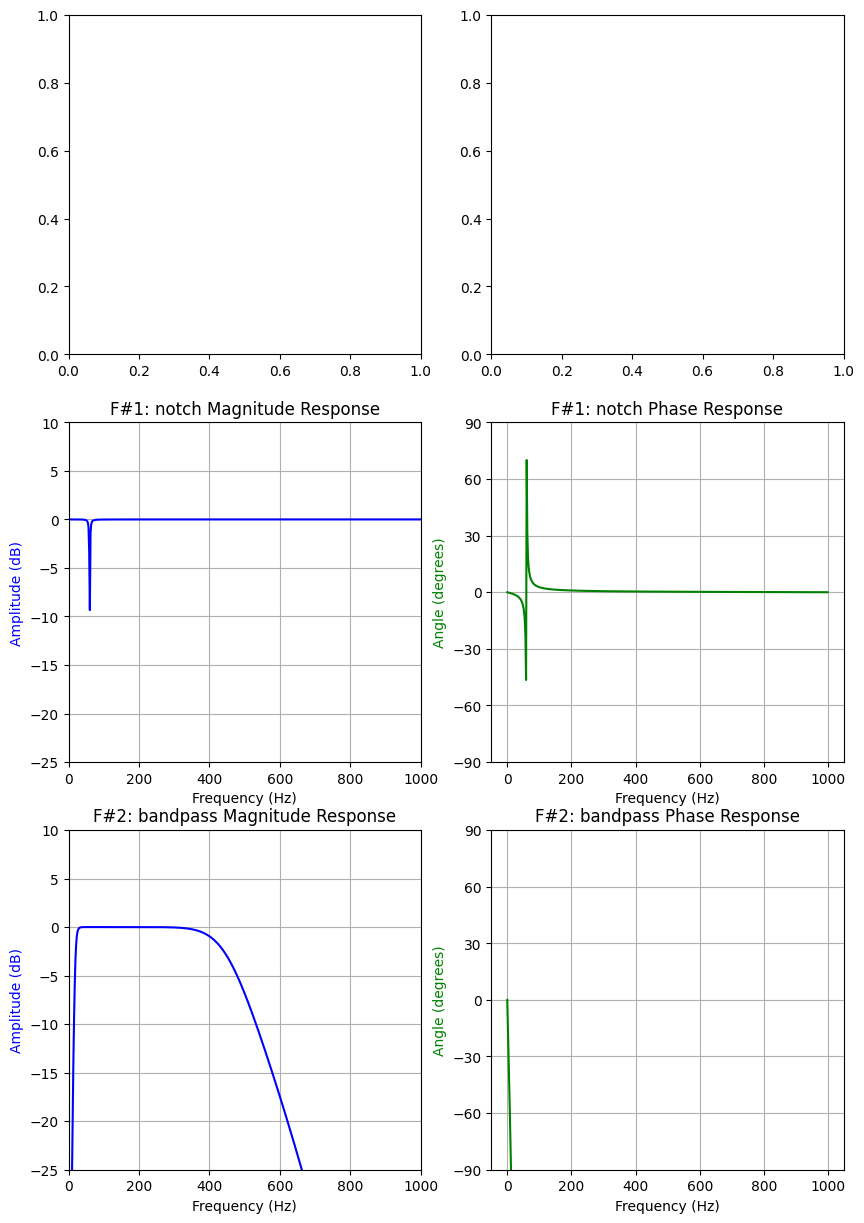

filtered_windows_0 [[[ 3.39754143e-02 -1.97016784e-03 -3.22704488e-02 ...  1.60256333e-02
    4.68221026e-02  6.33445686e-02]]

 [[ 1.42708395e+00  1.01967239e+00  3.06538162e-01 ... -1.39034856e-01
    6.77197005e-01  1.29667060e+00]]

 [[ 1.63010336e+00  1.48639642e+00  9.47109326e-01 ... -7.99065394e-01
    3.26121626e-01  1.27037618e+00]]

 ...

 [[ 2.53521119e+00  1.55767472e+00  2.13527513e-01 ...  1.28502769e+00
    2.85222607e+00  3.22974470e+00]]

 [[ 2.15263902e+00  1.66055146e+00  7.07470454e-01 ...  4.30583124e-01
    1.76541209e+00  2.36320082e+00]]

 [[ 4.09041701e-01  1.98688476e-01 -6.15923897e-02 ...  3.49226895e-01
    5.48817279e-01  5.43505764e-01]]]
filtered_windows_0 shape (12543, 1, 200)
Vérification de la standardisation des features :
LS - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000

MFL - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

MSR - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

WAMP - Dimension 0:
  Moyenne  : -0.0000
  Écar

In [16]:
odh.get_data(folder_location=folder_location_0, regex_filters=emg_regex_filters)
windows_0, metadata_0 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
print("windows_0", windows_0)
print("windows_0 shape", windows_0.shape)
print("metadata_0 classes", metadata_0['classes'])
print("metadata_0 reps", metadata_0['reps'])
print("metadata_0 classes shape", metadata_0['classes'].shape)
fi_emg = filtering.Filter(2000)
    
standardize_filter = { "name": "standardize" , "data": odh}
emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}

fi_emg.install_filters(standardize_filter)
fi_emg.install_filters(emg_notch_filter)
fi_emg.install_filters(emg_bandpass_filter)

fi_emg.visualize_filters()

# 2. Filter the RAW DATA
filtered_windows_0 = fi_emg.filter(windows_0)
print("filtered_windows_0", filtered_windows_0)
print("filtered_windows_0 shape", filtered_windows_0.shape)

fe = feature_extractor.FeatureExtractor()
feature_dic_0 = {
    'training_features': fe.extract_feature_group("LS4", filtered_windows_0),  # <-- Use filtered_windows
    'training_labels': metadata_0['classes']
}
standardized_feature_dic_0 = standardize_features(feature_dic_0)
verify_standardize(standardized_feature_dic_0, ['LS', 'MFL', 'MSR', 'WAMP'])
print("feature_dic_0", standardized_feature_dic_0)
print("feature_dic_0 LS", standardized_feature_dic_0['training_features']['LS'])
print("feature_dic_0 MFL", standardized_feature_dic_0['training_features']['MFL'])
print("feature_dic_0 MSR", standardized_feature_dic_0['training_features']['MSR'])
print("feature_dic_0 WAMP", standardized_feature_dic_0['training_features']['WAMP'])

    

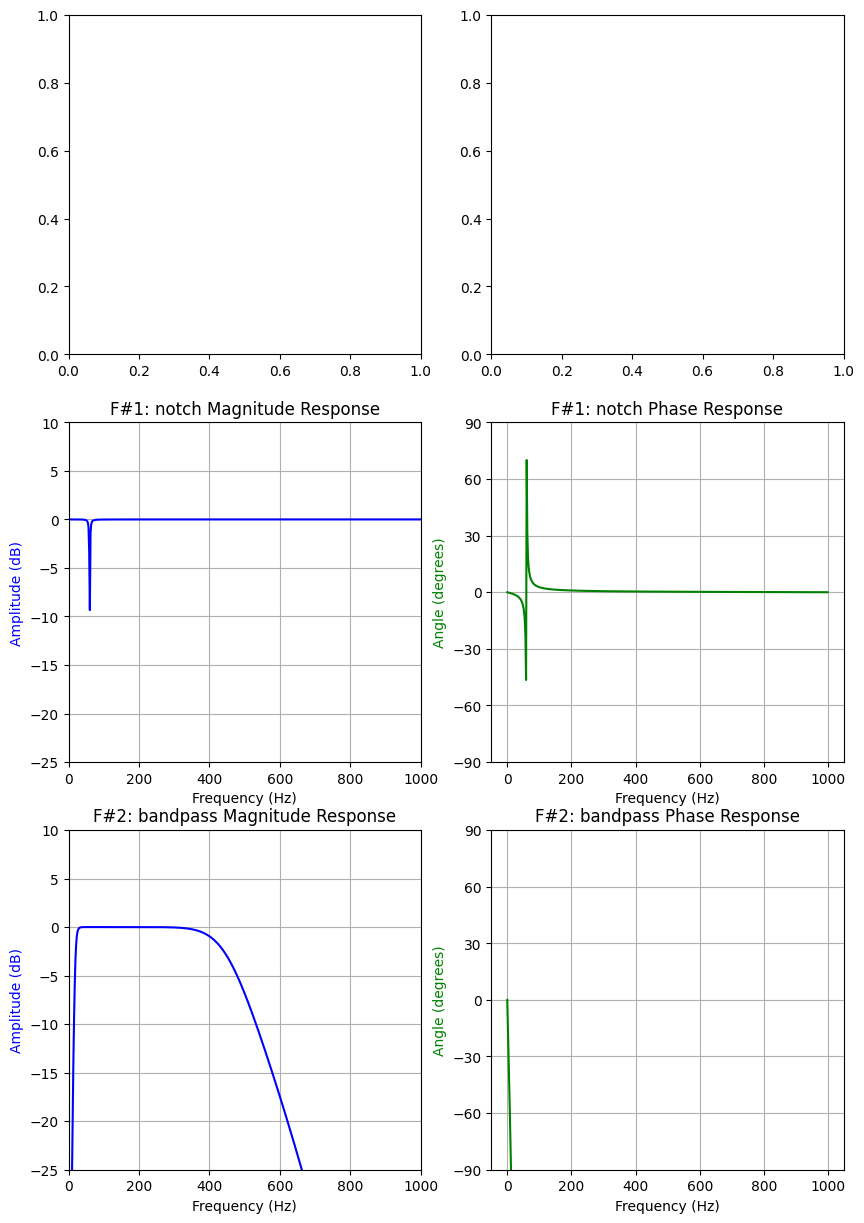

In [17]:
fi_emg.visualize_filters()

In [18]:

verify_standardize(standardized_feature_dic_0, ["LS", "MFL", "MSR", "WAMP"])


Vérification de la standardisation des features :
LS - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000

MFL - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

MSR - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

WAMP - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000



In [19]:

odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_1, regex_filters=emg_regex_filters)
windows_1, metadata_1 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
print("windows_1", windows_1)
print("windows_1 shape", windows_1.shape)
print("metadata_1 classes", metadata_1['classes'])
print("metadata_1 reps", metadata_1['reps'])
print("metadata_1 classes shape", metadata_1['classes'].shape)
fi_emg = filtering.Filter(2000)
standardize_filter = { "name": "standardize" , "data": odh}
emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}

fi_emg.install_filters(standardize_filter)
fi_emg.install_filters(emg_notch_filter)
fi_emg.install_filters(emg_bandpass_filter)
# 2. Filter the RAW DATA
filtered_windows_1 = fi_emg.filter(windows_1)
print("filtered_windows_1", filtered_windows_1)
print("filtered_windows_1 shape", filtered_windows_1.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_1 = {
    'training_features': fe.extract_feature_group("LS4", filtered_windows_1),  # <-- Use filtered_windows
    'training_labels': metadata_1['classes']
}
standardized_feature_dic_1 = standardize_features(feature_dic_1)
verify_standardize(standardized_feature_dic_1, ['LS', 'MFL', 'MSR', 'WAMP'])
print("feature_dic_1", standardized_feature_dic_1)
print("feature_dic_1 LS", standardized_feature_dic_1['training_features']['LS'])
print("feature_dic_1 MFL", standardized_feature_dic_1['training_features']['MFL'])
print("feature_dic_1 MSR", standardized_feature_dic_1['training_features']['MSR'])
print("feature_dic_1 WAMP", standardized_feature_dic_1['training_features']['WAMP'])



25 data files fetched out of 150 files.
windows_1 [[[-7.08896803e-04 -8.75283946e-04 -8.99366296e-04 ...  1.33547576e-03
    5.25870945e-04 -2.36882749e-04]]

 [[ 6.58104938e-04  4.05021336e-04 -7.66256581e-05 ...  6.64234991e-04
    8.05664062e-04  7.73700217e-04]]

 [[ 7.15464716e-04  1.03904392e-03  1.09552798e-03 ... -7.15902577e-04
   -3.57732358e-04  1.69890031e-04]]

 ...

 [[ 3.76560377e-04  1.17784583e-04 -1.33985436e-04 ...  3.17449155e-04
    4.97847847e-04  5.14486562e-04]]

 [[ 2.03605320e-04  1.58505647e-04  2.93366805e-05 ... -2.95556110e-04
   -1.41866933e-04  7.22470491e-05]]

 [[-3.02561884e-04 -1.93972380e-04  9.19507897e-06 ... -3.18324877e-04
   -3.21827764e-04 -3.08254076e-04]]]
windows_1 shape (12493, 1, 200)
metadata_1 classes [0 0 0 ... 4 4 4]
metadata_1 reps [0 0 0 ... 4 4 4]
metadata_1 classes shape (12493,)
filtered_windows_1 [[[ 0.06479066  0.06623235  0.05309532 ... -0.0513173  -0.00807553
    0.03550194]]

 [[ 1.96205576  2.20244027  1.86246332 ... -1.775

In [20]:
verify_standardize(standardized_feature_dic_1, ["LS", "MFL", "MSR", "WAMP"])

Vérification de la standardisation des features :
LS - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

MFL - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000

MSR - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000

WAMP - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000



In [ ]:

# odh = data_handler.OfflineDataHandler()
# odh.get_data(folder_location=folder_location_2, regex_filters=emg_regex_filters)
# windows_2, metadata_2 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
# print("windows_2", windows_2)
# print("windows_2 shape", windows_2.shape)
# print("metadata_2 classes", metadata_2['classes'])
# print("metadata_2 reps", metadata_2['reps'])
# print("metadata_2 classes shape", metadata_2['classes'].shape)
# fi_emg = filtering.Filter(2000)
# standardize_filter = { "name": "standardize" , "data": odh}
# emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
# emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}

# fi_emg.install_filters(standardize_filter)
# fi_emg.install_filters(emg_notch_filter)
# fi_emg.install_filters(emg_bandpass_filter)
# # 2. Filter the RAW DATA
# filtered_windows_2 = fi_emg.filter(windows_2)
# print("filtered_windows_2", filtered_windows_2)
# print("filtered_windows_2 shape", filtered_windows_2.shape)
# fe = feature_extractor.FeatureExtractor()
# feature_dic_2 = {
#     'training_features': fe.extract_feature_group("LS4", filtered_windows_2),  # <-- Use filtered_windows
#     'training_labels': metadata_2['classes']
# }
# standardized_feature_dic_2 = standardize_features(feature_dic_2)
# verify_standardize(standardized_feature_dic_2, ['LS', 'MFL', 'MSR', 'WAMP'])
# print("feature_dic_2", standardized_feature_dic_2)
# print("feature_dic_2 LS", standardized_feature_dic_2['training_features']['LS'])
# print("feature_dic_2 MFL", standardized_feature_dic_2['training_features']['MFL'])
# print("feature_dic_2 MSR", standardized_feature_dic_2['training_features']['MSR'])
# print("feature_dic_2 WAMP", standardized_feature_dic_2['training_features']['WAMP'])



25 data files fetched out of 150 files.
windows_2 [[[-1.57629925e-05 -1.35736880e-05 -1.09465226e-05 ... -2.18930452e-06
    1.31358271e-06  8.31935717e-06]]

 [[ 2.62716542e-06 -1.31358271e-06 -3.94074813e-06 ...  3.50288723e-06
    6.13005265e-06  5.69219175e-06]]

 [[ 3.50288723e-06  4.37860904e-07  1.75144361e-06 ...  8.75721807e-07
    0.00000000e+00 -1.31358271e-06]]

 ...

 [[-1.48872707e-05 -1.83901579e-05 -1.66387143e-05 ...  2.18930452e-06
    0.00000000e+00 -2.62716542e-06]]

 [[-8.31935717e-06 -1.35736880e-05 -1.48872707e-05 ... -1.22601053e-05
   -9.19507897e-06 -2.62716542e-06]]

 [[-3.85317595e-05 -3.98453422e-05 -2.97745414e-05 ...  1.31358271e-06
   -1.05086617e-05 -1.62008534e-05]]]
windows_2 shape (12500, 1, 200)
metadata_2 classes [0 0 0 ... 4 4 4]
metadata_2 reps [0 0 0 ... 4 4 4]
metadata_2 classes shape (12500,)
filtered_windows_2 [[[-1.45907134e-03  6.40058126e-04  3.78930675e-04 ... -2.54512919e-03
   -5.00532812e-03 -5.48206375e-03]]

 [[ 4.59937896e-01  2.788

In [ ]:
# verify_standardize(standardized_feature_dic_2, ["LS", "MFL", "MSR", "WAMP"])

Vérification de la standardisation des features :
LS - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

MFL - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000

MSR - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000

WAMP - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000



In [ ]:

# odh = data_handler.OfflineDataHandler()
# odh.get_data(folder_location=folder_location_3, regex_filters=emg_regex_filters)
# windows_3, metadata_3 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
# print("windows_3", windows_3)
# print("windows_3 shape", windows_3.shape)
# print("metadata_3 classes", metadata_3['classes'])
# print("metadata_3 reps", metadata_3['reps'])
# print("metadata_3 classes shape", metadata_3['classes'].shape)
# fi_emg = filtering.Filter(2000)
# standardize_filter = { "name": "standardize" , "data": odh}
# emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
# emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}

# fi_emg.install_filters(standardize_filter)
# fi_emg.install_filters(emg_notch_filter)
# fi_emg.install_filters(emg_bandpass_filter)
# # 2. Filter the RAW DATA
# filtered_windows_3 = fi_emg.filter(windows_3)
# print("filtered_windows_3", filtered_windows_3)
# print("filtered_windows_3 shape", filtered_windows_3.shape)
# fe = feature_extractor.FeatureExtractor()
# feature_dic_3 = {
#     'training_features': fe.extract_feature_group("LS4", filtered_windows_3),  # <-- Use filtered_windows
#     'training_labels': metadata_3['classes']
# }
# standardized_feature_dic_3 = standardize_features(feature_dic_3)
# verify_standardize(standardized_feature_dic_3, ['LS', 'MFL', 'MSR', 'WAMP'])
# print("feature_dic_3", standardized_feature_dic_3)
# print("feature_dic_3 LS", standardized_feature_dic_3['training_features']['LS'])
# print("feature_dic_3 MFL", standardized_feature_dic_3['training_features']['MFL'])
# print("feature_dic_3 MSR", standardized_feature_dic_3['training_features']['MSR'])
# print("feature_dic_3 WAMP", standardized_feature_dic_3['training_features']['WAMP'])



25 data files fetched out of 150 files.
windows_3 [[[ 8.75721807e-07 -1.75144361e-06 -4.37860904e-06 ...  1.44494098e-05
    7.00577446e-06  8.75721807e-07]]

 [[ 0.00000000e+00  8.75721807e-07  2.18930452e-06 ... -1.31358271e-06
   -4.37860904e-06 -4.81646994e-06]]

 [[-8.75721807e-07 -8.75721807e-06 -1.31358271e-05 ...  2.62716542e-06
    1.75144361e-06  0.00000000e+00]]

 ...

 [[ 1.31358271e-06  4.37860904e-06  5.25433084e-06 ... -3.06502632e-06
   -6.13005265e-06 -4.37860904e-06]]

 [[-4.81646994e-06 -4.37860904e-06 -2.62716542e-06 ...  5.25433084e-06
    7.88149626e-06  8.31935717e-06]]

 [[ 3.06502632e-06 -4.37860904e-07 -3.06502632e-06 ...  6.13005265e-06
    1.22601053e-05  1.48872707e-05]]]
windows_3 shape (12506, 1, 200)
metadata_3 classes [0 0 0 ... 4 4 4]
metadata_3 reps [0 0 0 ... 4 4 4]
metadata_3 classes shape (12506,)
filtered_windows_3 [[[ 4.50163938e-03  1.26891495e-02  2.30261232e-02 ... -5.75590529e-03
    4.85102101e-03 -5.75193807e-04]]

 [[-3.35071410e-02 -7.165

In [ ]:
# verify_standardize(standardized_feature_dic_3, ["LS", "MFL", "MSR", "WAMP"])

Vérification de la standardisation des features :
LS - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

MFL - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

MSR - Dimension 0:
  Moyenne  : -0.0000
  Écart-type: 1.0000

WAMP - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000



In [ ]:

# odh = data_handler.OfflineDataHandler()
# odh.get_data(folder_location=folder_location_4, regex_filters=emg_regex_filters)
# windows_4, metadata_4 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
# print("windows_4", windows_4)
# print("windows_4 shape", windows_4.shape)
# print("metadata_4 classes", metadata_4['classes'])
# print("metadata_4 reps", metadata_4['reps'])
# print("metadata_4 classes shape", metadata_4['classes'].shape)
# fi_emg = filtering.Filter(2000)
# standardize_filter = { "name": "standardize" , "data": odh}
# emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
# emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}

# fi_emg.install_filters(standardize_filter)
# fi_emg.install_filters(emg_notch_filter)
# fi_emg.install_filters(emg_bandpass_filter)
# # 2. Filter the RAW DATA
# filtered_windows_4 = fi_emg.filter(windows_4)
# print("filtered_windows_4", filtered_windows_4)
# print("filtered_windows_4 shape", filtered_windows_4.shape)
# fe = feature_extractor.FeatureExtractor()
# feature_dic_4 = {
#     'training_features': fe.extract_feature_group("LS4", filtered_windows_4),  # <-- Use filtered_windows
#     'training_labels': metadata_4['classes']
# }
# standardized_feature_dic_4 = standardize_features(feature_dic_4)
# verify_standardize(standardized_feature_dic_4, ['LS', 'MFL', 'MSR', 'WAMP'])
# print("feature_dic_4", standardized_feature_dic_4)
# print("feature_dic_4 LS", standardized_feature_dic_4['training_features']['LS'])
# print("feature_dic_4 MFL", standardized_feature_dic_4['training_features']['MFL'])
# print("feature_dic_4 MSR", standardized_feature_dic_4['training_features']['MSR'])
# print("feature_dic_4 WAMP", standardized_feature_dic_4['training_features']['WAMP'])



25 data files fetched out of 150 files.
windows_4 [[[ 4.33920155e-04  5.83668584e-04  5.08794370e-04 ... -6.25703231e-04
   -3.19638460e-04  1.27417523e-04]]

 [[-1.70765752e-04  1.60257091e-04  3.73933212e-04 ... -5.40320355e-04
   -6.03810186e-04 -4.54061757e-04]]

 [[-4.03707753e-04 -3.12632685e-04 -2.09735373e-04 ... -1.35736880e-05
   -2.96431832e-04 -4.11589249e-04]]

 ...

 [[ 3.94074813e-06 -1.75144361e-06 -7.00577446e-06 ... -3.94074813e-06
   -6.13005265e-06 -2.62716542e-06]]

 [[ 3.94074813e-06  8.75721807e-07 -1.75144361e-06 ...  0.00000000e+00
    0.00000000e+00  2.18930452e-06]]

 [[-7.44363536e-06 -9.63293988e-06 -3.50288723e-06 ...  1.75144361e-06
    0.00000000e+00 -1.75144361e-06]]]
windows_4 shape (12518, 1, 200)
metadata_4 classes [0 0 0 ... 4 4 4]
metadata_4 reps [0 0 0 ... 4 4 4]
metadata_4 classes shape (12518,)
filtered_windows_4 [[[-1.90175023e-01 -1.48583967e-01 -6.19531513e-02 ...  3.94719390e-03
   -1.25813972e-01 -2.16615250e-01]]

 [[-6.92243523e+00 -6.008

In [ ]:
# verify_standardize(standardized_feature_dic_4, ["LS", "MFL", "MSR", "WAMP"])

Vérification de la standardisation des features :
LS - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

MFL - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

MSR - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000

WAMP - Dimension 0:
  Moyenne  : 0.0000
  Écart-type: 1.0000



In [ ]:
# filtered_windows = np.concatenate(( filtered_windows_0,filtered_windows_1,filtered_windows_2,filtered_windows_3))
# print("filtered_windows shape", filtered_windows.shape)
# print("filtered_windows", filtered_windows)



filtered_windows shape (50090, 1, 200)
filtered_windows [[[-0.0019052  -0.0045811  -0.0079458  ... -0.00699244 -0.00488508
   -0.00627031]]

 [[ 0.07916572  0.04505767  0.02104519 ...  0.1986599   0.2532899
    0.25348136]]

 [[ 0.08728485  0.06464204  0.0345721  ...  0.23339816  0.3020684
    0.32309402]]

 ...

 [[-0.09142081  0.26267359  0.41801373 ... -0.26245313 -0.70087816
   -0.81149633]]

 [[-0.1310946   0.16623521  0.32869439 ... -0.14729497 -0.53468065
   -0.63879511]]

 [[ 0.05369495  0.07530043  0.05199242 ...  0.05338256 -0.06213317
   -0.13803124]]]


In [ ]:
# feature_dic = {
#         'training_features': {},
#         'training_labels': None
#     }
# feature_dic['training_features']["LS"] = np.concatenate((
#     standardized_feature_dic_0['training_features']['LS'],
#     standardized_feature_dic_1['training_features']['LS'],
#     standardized_feature_dic_2['training_features']['LS'],
#     standardized_feature_dic_3['training_features']['LS'],
#     #standardized_feature_dic_4['training_features']['LS']
# ))
# print("LS features : ", feature_dic['training_features']["LS"])



# # Concatenate MFL features
# feature_dic['training_features']["MFL"] = np.concatenate((
#     standardized_feature_dic_0['training_features']['MFL'],
#     standardized_feature_dic_1['training_features']['MFL'],
#     standardized_feature_dic_2['training_features']['MFL'],
#     standardized_feature_dic_3['training_features']['MFL'],
#     #standardized_feature_dic_4['training_features']['MFL']
# ))
# print("MFL features : ", feature_dic['training_features']["MFL"])

# # Concatenate MSR features
# feature_dic['training_features']["MSR"] = np.concatenate((
#     standardized_feature_dic_0['training_features']['MSR'],
#     standardized_feature_dic_1['training_features']['MSR'],
#     standardized_feature_dic_2['training_features']['MSR'],
#     standardized_feature_dic_3['training_features']['MSR'],
#     #standardized_feature_dic_4['training_features']['MSR']
# ))
# print("MSR features : ", feature_dic['training_features']["MSR"])

# # Concatenate WAMP features
# feature_dic['training_features']["WAMP"] = np.concatenate((
#     standardized_feature_dic_0['training_features']['WAMP'],
#     standardized_feature_dic_1['training_features']['WAMP'],
#     standardized_feature_dic_2['training_features']['WAMP'],
#     standardized_feature_dic_3['training_features']['WAMP'],
#     #standardized_feature_dic_4['training_features']['WAMP']
# ))
# print("WAMP features : ", feature_dic['training_features']["WAMP"])

# # Concatenate all labels
# feature_dic['training_labels'] = np.concatenate((
#     feature_dic_0['training_labels'],
#     feature_dic_1['training_labels'],
#     feature_dic_2['training_labels'],
#     feature_dic_3['training_labels'],
#     #feature_dic_4['training_labels']
# ))
# print("feature_dic['training_labels'] : ", feature_dic['training_labels'])

LS features :  [[-0.20608519]
 [-0.07232918]
 [-0.00952209]
 ...
 [ 0.16238682]
 [ 0.00387414]
 [-0.39712027]]
MFL features :  [[-9.71973913]
 [ 0.9872759 ]
 [ 1.95736097]
 ...
 [ 3.25006767]
 [ 1.89608707]
 [-6.66413277]]
MSR features :  [[-0.92722731]
 [-0.21503425]
 [-0.0247317 ]
 ...
 [ 0.42896084]
 [-0.03781277]
 [-1.27912958]]
WAMP features :  [[-28.93647213]
 [  1.21300182]
 [  1.50290061]
 ...
 [  0.81986201]
 [  0.81986201]
 [ -1.10972728]]
feature_dic['training_labels'] :  [0 0 0 ... 4 4 4]


In [21]:
print("Distribution des classes :", np.unique(feature_dic_0['training_labels'], return_counts=True))

Distribution des classes : (array([0, 1, 2, 3, 4], dtype=int64), array([2497, 2524, 2513, 2507, 2502], dtype=int64))


In [22]:
model = emg_predictor.EMGClassifier("LDA")
model.fit(feature_dictionary=feature_dic_0)
model.add_rejection(0.6)



In [23]:
predictions , probabilities = model.run(test_data=feature_dic_1['training_features'])
print("predictions", predictions)
print("probabilities", probabilities)
np.unique(predictions, return_counts=True)

predictions [ 0  3  3 ... -1 -1  0]
probabilities [0.9599895  0.61823875 0.73063841 ... 0.4220135  0.46075774 0.88712069]


(array([-1,  0,  3]), array([9606, 2882,    5], dtype=int64))

In [24]:
OfflineMetrics = OfflineMetrics()
OfflineMetrics.extract_common_metrics(y_true=feature_dic_1['training_labels'], y_predictions=predictions)

AER not computed... Please input the null_label parameter.


{'CA': 0.0010391409767925182, 'INS': 0.0}

In [25]:
OfflineMetrics.get_CONF_MAT(y_true=feature_dic_1['training_labels'], y_predictions=predictions)

array([[3.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00],
       [2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [5.200e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.356e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [26]:
OfflineMetrics.get_RECALL(y_true=feature_dic_1['training_labels'], y_predictions=predictions)

0.0010391409767925182

In [27]:
OfflineMetrics.get_PREC(y_true=feature_dic_1['training_labels'], y_predictions=predictions)

ZeroDivisionError: division by zero

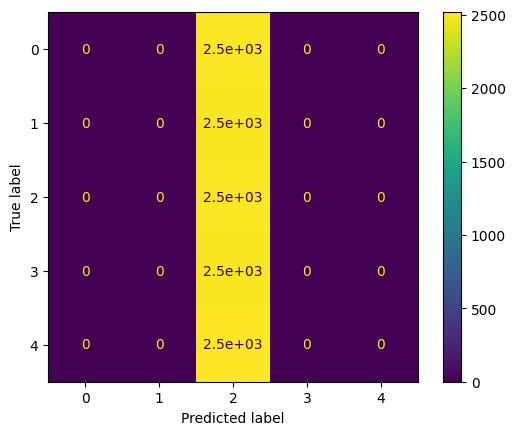

In [44]:
OfflineMetrics.visualize_conf_matrix(OfflineMetrics.get_CONF_MAT(y_true=feature_dic_4['training_labels'], y_predictions=predictions))